In [1]:
# General 
import numpy as np
import pandas as pd
from scipy import stats
# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Connectomes and network analysis
import conntility
# Specific to this project
import sys 
sys.path.append('../../../library')
from structural_basic import load_connectome
from utils_microns_bbp import *
from plotting_utils import *

#### Load precomputed data 

In [2]:
configs={} #Paths to activity and structural data 

# Paths to data and specs 
configs["BBP"]={
    "connectome_dir":"../../data",
    "simplicial_dir":"../../data",
    "fname_reliability":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA_Baseline/working_dir/reliability_basic.npz",
    "fname_CC": "/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/working_dir/coupling_coefficients.pkl",
    "norm_types": ["global", "per_cell"],
    "fname_rates":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/toposample_input/raw_spikes_exc.npy",
    "format_rates":"toposample",
    "bin_size":"2p0", 
    "fname_effciency":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_signals.pkl",
    "properties":["CC", "CC_norm_cell", "reliability", "efficiency"], 
    "stypes":["all", "maximal"],
    "base_graph": "original"
}

configs["MICrONS"]={
    "connectome_dir":"../../data",
    "simplicial_dir":"../../data",
    "fname_reliability":"/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "fname_CC": "/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "norm_types": ["global", "per_cell"],
    "fname_rates": "/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "format_rates":None,
    "bin_size":None, 
    "save_dir":"../../data", 
    "average_type":["per_layer", "full"], 
    "properties":["CC", "CC_norm_cell", "reliability"], 
    "stypes":["all", "maximal"],
    "base_graph": "original"
}

connectomes, simp_layer_raw, simp_full_raw ={}, {}, {}

#Load precomputed data 
conns=["MICrONS", "BBP"]
for conn in conns:
    cfg=configs[conn]
    stypes=cfg["stypes"]
    base_graph=cfg["base_graph"]
    # Get connectome and porperties per node 
    connectome=load_connectome(cfg["connectome_dir"], conn)
    connectome = add_layers(connectome,conn)
    connectome = add_reliability(connectome, conn, cfg["fname_reliability"])
    connectome = add_firing_rates(connectome,conn, cfg["fname_rates"], cfg["format_rates"]) 
    for norm_type in cfg["norm_types"]:
        connectome = add_cc(connectome, cfg["fname_CC"], norm_type)#, bin_size=cfg["bin_size"]) double check bin size option 
    connectomes[conn]=connectome
    # Adding properties of neighbohoords 
    nbd_props=pd.read_pickle(f'/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/props_{conn}_original.pkl')
    for col in nbd_props.columns:
        connectomes[conn].add_vertex_property(new_label=col,new_values=nbd_props[col].to_numpy())
    
# Load dimension of activity (BBP only)
conn="BBP"
connectomes[conn]=add_efficiency(connectomes[conn], configs[conn]["fname_effciency"])


### Plot figure

In [3]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
#conversion=1.5

marker_size=2
linewidth=2; linewidth_base=1; linestyle_base="dotted"; alpha_base=0.75

# Setting up colors 
colors={
    'high complexity': 'tab:purple', 
    'low complexity': 'tab:cyan', 
    2:matplotlib.colormaps["Set3"](0),
    3:matplotlib.colormaps["Set3"](2),
    4:matplotlib.colormaps["Set3"](5),
    5:matplotlib.colormaps["Set3"](4),
    6:matplotlib.colormaps["Set3"](3),
    "all":"C0",
    "sink": "C1",
    "source":"C2"
}
markers={"all":"o",
       "sink": ">",
       "source":"<"}
alpha=0.25

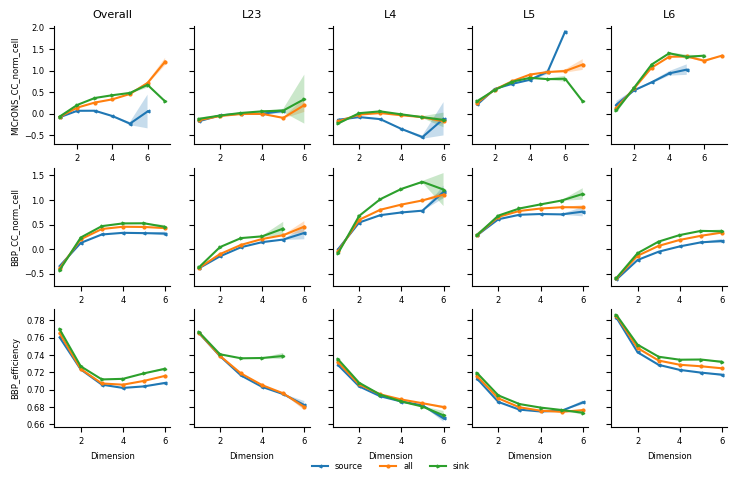

In [6]:
layers=["L23", "L4", "L5", "L6"]
# Get simplicial structure  
for conn in conns: 
    cfg=configs[conn]
    simp_layer_raw[conn], simp_full_raw[conn] ={}, {}
    for property in cfg["properties"]:
        fname=f"{cfg['simplicial_dir']}/node_stats_per_layer_{property}_{conn}_{base_graph}.pkl"
        simp_layer_raw[conn][property]=pd.read_pickle(fname)
        fname=f"{cfg['simplicial_dir']}/node_stats_full_{property}_{conn}_{base_graph}.pkl"
        simp_full_raw[conn][property]=pd.read_pickle(fname)

# Reformat for plotting 
simplicial_full=agg_along_dims_single(simp_full_raw)
simplicial_layers=agg_along_dims_layers(simp_layer_raw)


# Plotting figure prototype 
width=21*0.7/conversion


rows=3; cols=5
fig, axs =plt.subplots(rows,cols,figsize=(width*1.5, width*rows*1.5/cols), sharex=False, sharey="row")
# Coupling across simplices 
stype="maximal" # Consider maximal simplices
for j, l in enumerate(["Overall"]+layers):
#for j, l in enumerate(["L23"]):
    axs[0,j].set_title(f"{l}", fontsize=titlesize)
    for pos in ["source", "all", "sink"]: 
        for i, conn in enumerate(conns+["BBP"]):
            if i<2:
                property="CC_norm_cell"
            else:
                property="efficiency"; conn="BBP"
            if l =="Overall":
                df=simplicial_full[conn][property][stype][pos]
            else: 
                df=simplicial_layers[l][conn][property][stype][pos]
            plot_and_fill(axs[i,j], df, pos, colors[pos], marker_size, markers[pos], alpha=alpha)                        
            axs[i,j].spines[["top", "right"]].set_visible(False)
            axs[i,0].set_ylabel(f"{conn}_{property}", fontsize=labelsize)
            axs[-1,j].set_xlabel("Dimension", fontsize=labelsize)
            axs[i,j].tick_params(labelsize=ticksize)
axs[-1,2].legend(frameon=False, ncols=3, loc="center", bbox_to_anchor=(0.5, -0.33),fontsize=labelsize)
fig.savefig(f"figs/CC_efficiency__per_layer_both_connectomes_supp.svg", transparent=True, bbox_inches="tight")